# 04 – QA Prioritization & CI Risk Gate Demo

## Purpose
This notebook demonstrates how to:
- Take the **CatBoost classifier** output (risk_score)
- Combine it with **code_churn_score** using historical bounds
- Produce a **QA_priority_score** and bucket (Critical / High / Medium / Low)
- Export a CSV for **Tableau / dashboards**
- Demonstrate how this ties into the `risk_gate.py` CI script

## Inputs
- `data/Processed/scored_test_patch_features.csv` (ML predictions)

## Outputs
- `data/Processed/firmware_qa_priority.csv` (QA prioritization scores)

---

In [51]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import sys

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parents[0] if current_dir.name == "notebooks" else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import PROCESSED_DATA_DIR, MODELS_DIR, PROJECT_ROOT

# For backward compatibility
DATA_DIR = PROCESSED_DATA_DIR

print("✅ Configuration loaded")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Project root: {PROJECT_ROOT}")

# Load the scored file from risk_gate.py (located in project root)
scored_file = PROJECT_ROOT / "scored_test_patch_features.csv"

if not scored_file.exists():
    raise FileNotFoundError(
        f"Expected scored file not found at {scored_file.resolve()}. \\n"
        f"Please ensure you run 'python risk_gate.py data/test_patch_features.csv' from the project root first."
    )

scored_df = pd.read_csv(scored_file)
print("\\n✅ Scored file loaded successfully.")
print(f"   - Rows: {len(scored_df):,}")
print(f"   - Columns: {scored_df.columns.tolist()}")
scored_df.head()

✅ Configuration loaded
📁 Data directory: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed
📁 Project root: /Users/hc/Documents/projects/roku-patch-stability-analytics
\n✅ Scored file loaded successfully.
   - Rows: 50
   - Columns: ['firmware_version', 'code_churn_score', 'previous_version_error_rate', 'avg_device_age_days', 'is_hotfix', 'patch_security', 'risk_score', 'high_risk_flag']


,firmware_version,code_churn_score,previous_version_error_rate,avg_device_age_days,is_hotfix,patch_security,risk_score,high_risk_flag
0,10.0.1,0.279867,0.000000,702.219142,False,False,0.016229,0
1,10.0.2,0.292176,452.759060,426.954965,False,False,0.005618,0
2,10.0.3,0.214577,2133.975495,336.319311,False,False,0.006206,0
3,10.0.4,0.172038,3624.725127,340.087869,False,False,0.620677,1
4,10.1.0,0.240462,2519.057153,467.025999,False,True,0.201233,0


In [52]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [53]:
# Historical churn bounds from training data (Notebook 03)
CHURN_HISTORICAL_MIN = 0.14
CHURN_HISTORICAL_MAX = 0.87

if CHURN_HISTORICAL_MAX <= CHURN_HISTORICAL_MIN:
    raise ValueError("Historical churn max must be > min. Check the values.")

# Weights for composite QA priority score
# Can be tuned later – these are reasonable starting values.
W_MODEL = 0.6   # weight on CatBoost risk_score
W_CHURN = 0.4   # weight on normalized code_churn_score

# --- NEW: Define Bucketing Thresholds as Constants ---
CRITICAL_THRESHOLD = 0.85
HIGH_THRESHOLD = 0.65
MEDIUM_THRESHOLD = 0.40 # Implicit Low is below this

print("Historical churn min:", CHURN_HISTORICAL_MIN)
print("Historical churn max:", CHURN_HISTORICAL_MAX)
print("Weights -> model:", W_MODEL, "| churn:", W_CHURN)

Historical churn min: 0.14
Historical churn max: 0.87
Weights -> model: 0.6 | churn: 0.4


In [54]:
# Ensure required columns exist
required_cols = ["firmware_version", "code_churn_score", "risk_score"]
missing = [c for c in required_cols if c not in scored_df.columns]
if missing:
    raise ValueError(f"Missing required columns in scored_df: {missing}")

# 1) Normalize churn using training-set bounds
scored_df["churn_norm"] = (
    (scored_df["code_churn_score"] - CHURN_HISTORICAL_MIN)
    / (CHURN_HISTORICAL_MAX - CHURN_HISTORICAL_MIN + 1e-6)
)

# Clamp to [0, 1] in case a patch lands just outside the historical extremes
scored_df["churn_norm"] = scored_df["churn_norm"].clip(0.0, 1.0)

# 2) Composite priority score
scored_df["QA_priority_score"] = (
    W_MODEL * scored_df["risk_score"]
    + W_CHURN * scored_df["churn_norm"]
)

scored_df[["firmware_version", "code_churn_score", "churn_norm", "risk_score", "QA_priority_score"]].head()

,firmware_version,code_churn_score,churn_norm,risk_score,QA_priority_score
0,10.0.1,0.279867,0.191598,0.016229,0.086377
1,10.0.2,0.292176,0.208461,0.005618,0.086755
2,10.0.3,0.214577,0.102160,0.006206,0.044588
3,10.0.4,0.172038,0.043888,0.620677,0.389962
4,10.1.0,0.240462,0.137618,0.201233,0.175787


In [55]:
def bucket_priority(score: float) -> str:
    """Map composite score to a qualitative bucket."""
    # Use constants instead of hardcoded numbers
    if score >= CRITICAL_THRESHOLD:
        return "Critical"
    elif score >= HIGH_THRESHOLD:
        return "High"
    elif score >= MEDIUM_THRESHOLD:
        return "Medium"
    else:
        return "Low"
        
scored_df["QA_bucket"] = scored_df["QA_priority_score"].apply(bucket_priority)

# Quick sanity check
scored_df[["firmware_version", "QA_priority_score", "QA_bucket"]].head(10)

,firmware_version,QA_priority_score,QA_bucket
0,10.0.1,0.086377,Low
1,10.0.2,0.086755,Low
2,10.0.3,0.044588,Low
3,10.0.4,0.389962,Low
4,10.1.0,0.175787,Low
5,10.2.0,0.821120,High
6,10.3.0,0.041886,Low
7,10.4.0,0.697950,High
8,10.4.1,0.577457,Medium
9,10.4.2,0.287863,Low


In [56]:
qa_cols = [
    "firmware_version",
    "code_churn_score",
    "churn_norm",
    "risk_score",
    "high_risk_flag",
    "QA_priority_score",
    "QA_bucket",
]

qa_priority_path = DATA_DIR / "firmware_qa_priority.csv"
qa_priority_path.parent.mkdir(parents=True, exist_ok=True)

scored_df[qa_cols].to_csv(qa_priority_path, index=False)

print(f"✅ QA prioritization sheet saved to: {qa_priority_path}")
scored_df[qa_cols].sort_values("QA_priority_score", ascending=False).head(10)

✅ QA prioritization sheet saved to: /Users/hc/Documents/projects/roku-patch-stability-analytics/data/Processed/firmware_qa_priority.csv


,firmware_version,code_churn_score,churn_norm,risk_score,high_risk_flag,QA_priority_score,QA_bucket
14,10.5.4,0.684074,0.745306,0.972605,1,0.881685,Critical
5,10.2.0,0.585893,0.610811,0.961326,1,0.821120,High
47,10.10.0,0.451159,0.426245,0.968586,1,0.751650,High
11,10.5.1,0.385759,0.336655,0.977943,1,0.721428,High
7,10.4.0,0.340778,0.275038,0.979892,1,0.697950,High
36,10.7.5,0.242240,0.140055,0.979955,1,0.643995,Medium
10,10.5.0,0.265577,0.172023,0.930101,1,0.626870,Medium
49,10.10.2,0.205481,0.089701,0.961969,1,0.613062,Medium
42,10.7.11,0.143966,0.005433,0.970958,1,0.584748,Medium
8,10.4.1,0.199140,0.081014,0.908419,1,0.577457,Medium


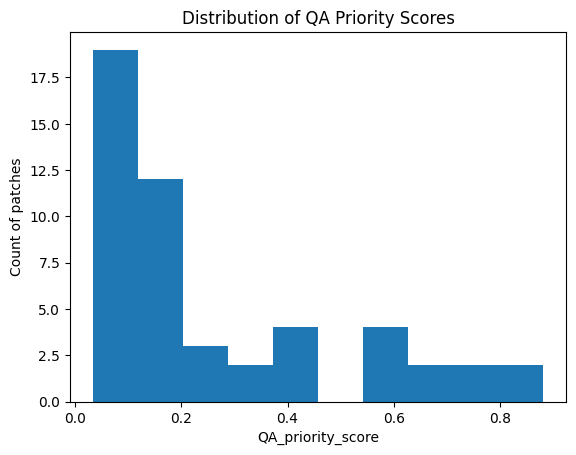

QA_bucket
Low         38
Medium       7
High         4
Critical     1
Name: count, dtype: int64

In [57]:
import matplotlib.pyplot as plt

plt.hist(scored_df["QA_priority_score"], bins=10)
plt.xlabel("QA_priority_score")
plt.ylabel("Count of patches")
plt.title("Distribution of QA Priority Scores")
plt.show()

scored_df["QA_bucket"].value_counts()

## CI Gate + QA Prioritization Summary

- `risk_gate.py` runs in CI and:
  - Loads the input patch feature file.
  - Uses the saved CatBoost classifier to compute `risk_score`.
  - Writes `scored_*.csv`.
  - Fails CI if any `high_risk_flag == 1`.

- This notebook:
  - Takes the `scored_*.csv` file.
  - Normalizes `code_churn_score` using historical training bounds.
  - Builds `QA_priority_score` from `risk_score` + churn.
  - Buckets patches into `Critical / High / Medium / Low`.
  - Outputs `firmware_qa_priority.csv` for Tableau and exec review.

## Validation Visualizations

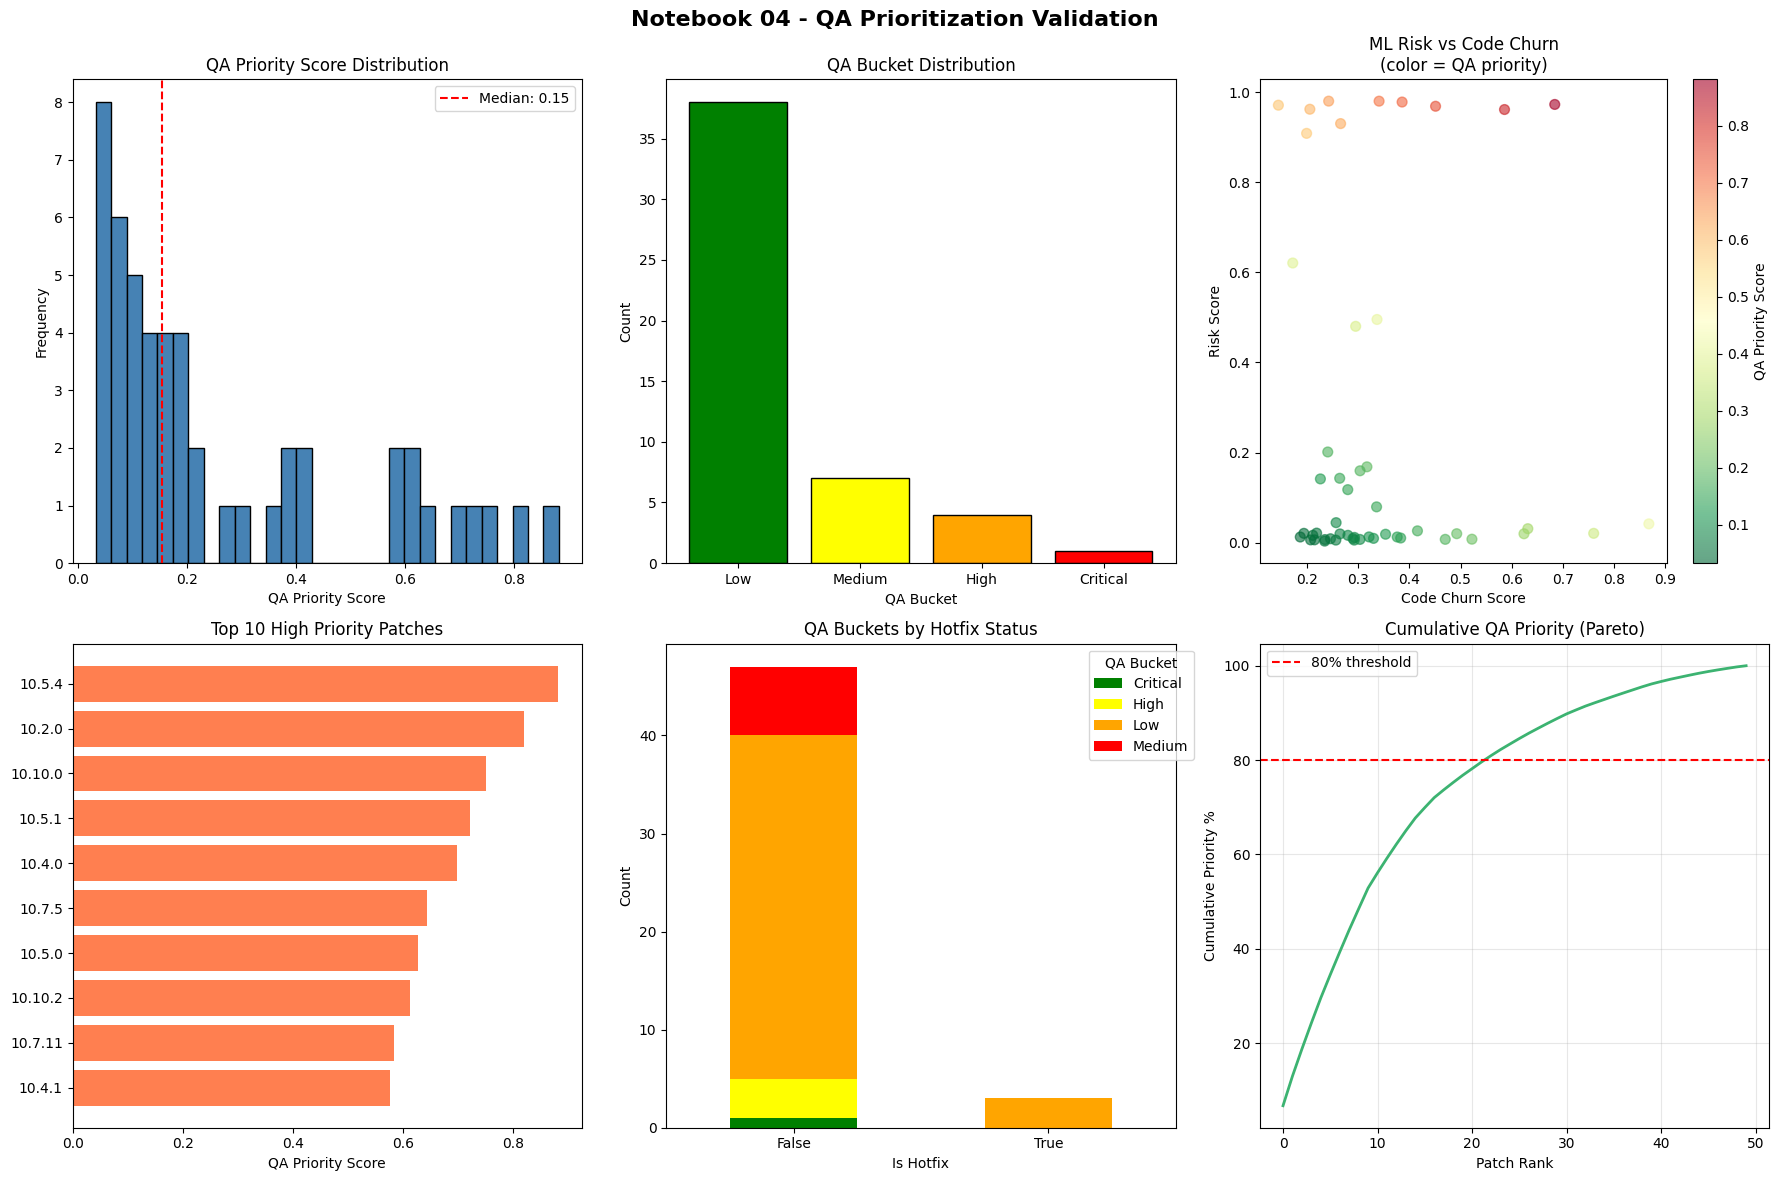


VALIDATION SUMMARY - QA Prioritization
Total patches prioritized: 50

QA bucket breakdown:
  Low: 38 (76.0%)
  Medium: 7 (14.0%)
  High: 4 (8.0%)
  Critical: 1 (2.0%)

QA priority score stats:
  Mean: 0.262
  Median: 0.154
  Std: 0.242
  Min: 0.033
  Max: 0.882

Top 3 priority patches:
  10.5.4: 0.882
  10.2.0: 0.821
  10.10.0: 0.752


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use scored_df which has all columns including is_hotfix
# (already loaded and processed earlier in this notebook)
qa_priority_df = scored_df.copy()

# Create comprehensive QA prioritization validation visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Notebook 04 - QA Prioritization Validation', fontsize=16, fontweight='bold')

# 1. QA Priority Score distribution
axes[0, 0].hist(qa_priority_df['QA_priority_score'], bins=30, color='steelblue', edgecolor='black')
axes[0, 0].axvline(qa_priority_df['QA_priority_score'].median(), color='red', 
                   linestyle='--', label=f'Median: {qa_priority_df["QA_priority_score"].median():.2f}')
axes[0, 0].set_xlabel('QA Priority Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('QA Priority Score Distribution')
axes[0, 0].legend()

# 2. Priority bucket distribution
bucket_counts = qa_priority_df['QA_bucket'].value_counts()
color_map = {'Critical': 'red', 'High': 'orange', 'Medium': 'yellow', 'Low': 'green'}
colors = [color_map.get(b, 'gray') for b in bucket_counts.index]
axes[0, 1].bar(bucket_counts.index, bucket_counts.values, color=colors, edgecolor='black')
axes[0, 1].set_xlabel('QA Bucket')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('QA Bucket Distribution')

# 3. ML Risk vs Code Churn (composite scoring)
if 'risk_score' in qa_priority_df.columns and 'code_churn_score' in qa_priority_df.columns:
    scatter = axes[0, 2].scatter(qa_priority_df['code_churn_score'], 
                                 qa_priority_df['risk_score'],
                                 c=qa_priority_df['QA_priority_score'], 
                                 cmap='RdYlGn_r', s=50, alpha=0.6)
    axes[0, 2].set_xlabel('Code Churn Score')
    axes[0, 2].set_ylabel('Risk Score')
    axes[0, 2].set_title('ML Risk vs Code Churn\n(color = QA priority)')
    plt.colorbar(scatter, ax=axes[0, 2], label='QA Priority Score')
else:
    axes[0, 2].text(0.5, 0.5, 'Risk/Churn features\nnot available', 
                   ha='center', va='center', transform=axes[0, 2].transAxes)

# 4. Top 10 patches by priority
top_10 = qa_priority_df.nlargest(10, 'QA_priority_score')
axes[1, 0].barh(range(10), top_10['QA_priority_score'].values, color='coral')
axes[1, 0].set_yticks(range(10))
axes[1, 0].set_yticklabels(top_10['firmware_version'].values if 'firmware_version' in top_10.columns 
                           else [f'Patch {i}' for i in range(10)])
axes[1, 0].set_xlabel('QA Priority Score')
axes[1, 0].set_title('Top 10 High Priority Patches')
axes[1, 0].invert_yaxis()

# 5. QA bucket by hotfix status
if 'is_hotfix' in qa_priority_df.columns:
    bucket_by_hotfix = pd.crosstab(qa_priority_df['is_hotfix'], qa_priority_df['QA_bucket'])
    bucket_by_hotfix.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                         color=['green', 'yellow', 'orange', 'red'])
    axes[1, 1].set_xlabel('Is Hotfix')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('QA Buckets by Hotfix Status')
    axes[1, 1].legend(title='QA Bucket', bbox_to_anchor=(1.05, 1))
    axes[1, 1].tick_params(axis='x', rotation=0)
else:
    axes[1, 1].text(0.5, 0.5, 'Hotfix status not available', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)

# 6. Cumulative priority distribution (Pareto-style)
sorted_priority = qa_priority_df['QA_priority_score'].sort_values(ascending=False).reset_index(drop=True)
cumulative_pct = (sorted_priority.cumsum() / sorted_priority.sum() * 100)
axes[1, 2].plot(cumulative_pct.values, color='mediumseagreen', linewidth=2)
axes[1, 2].axhline(80, color='red', linestyle='--', label='80% threshold')
axes[1, 2].set_xlabel('Patch Rank')
axes[1, 2].set_ylabel('Cumulative Priority %')
axes[1, 2].set_title('Cumulative QA Priority (Pareto)')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print validation summary
print("\n" + "="*60)
print("VALIDATION SUMMARY - QA Prioritization")
print("="*60)
print(f"Total patches prioritized: {len(qa_priority_df)}")
print(f"\nQA bucket breakdown:")
for bucket, count in bucket_counts.items():
    print(f"  {bucket}: {count} ({count/len(qa_priority_df)*100:.1f}%)")
print(f"\nQA priority score stats:")
print(f"  Mean: {qa_priority_df['QA_priority_score'].mean():.3f}")
print(f"  Median: {qa_priority_df['QA_priority_score'].median():.3f}")
print(f"  Std: {qa_priority_df['QA_priority_score'].std():.3f}")
print(f"  Min: {qa_priority_df['QA_priority_score'].min():.3f}")
print(f"  Max: {qa_priority_df['QA_priority_score'].max():.3f}")
print(f"\nTop 3 priority patches:")
for idx, row in qa_priority_df.nlargest(3, 'QA_priority_score').iterrows():
    fw_ver = row['firmware_version'] if 'firmware_version' in row else f"Patch {idx}"
    print(f"  {fw_ver}: {row['QA_priority_score']:.3f}")
print("="*60)